In [2]:
import sys
import os
import pandas as pd
from IPython.display import display

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from data_loader import load_fraud_data

# Load data
fraud_df = load_fraud_data("../data/Fraud_Data.csv")
print("✅ Fraud data loaded.")


✅ Fraud data loaded.


In [3]:
# Check total missing values
print("🔍 Total missing values in Fraud_Data:")
total_missing = fraud_df.isnull().sum()
display(total_missing[total_missing > 0])

# Summary
if total_missing.sum() == 0:
    print("✅ No missing values found.")
else:
    print("⚠️ Missing values found. Next step: drop or impute.")


🔍 Total missing values in Fraud_Data:


Series([], dtype: int64)

✅ No missing values found.


In [4]:
# Drop rows with missing values
fraud_df_clean = fraud_df.dropna()

print(f"✅ Dropped {fraud_df.shape[0] - fraud_df_clean.shape[0]} rows with missing values.")


✅ Dropped 0 rows with missing values.


In [5]:
 #Save cleaned version for later use
fraud_df_clean.to_csv("../data/fraud_data_clean.csv", index=False)


2,Data Cleaning

remove Duplicates

In [6]:
# Check and remove duplicates
duplicate_count = fraud_df_clean.duplicated().sum()
print(f"🧹 Found {duplicate_count} duplicate rows.")

fraud_df_clean = fraud_df_clean.drop_duplicates()
print(f"✅ Duplicate rows removed. Current shape: {fraud_df_clean.shape}")


🧹 Found 0 duplicate rows.
✅ Duplicate rows removed. Current shape: (151112, 11)


Inspect Data Types

In [7]:
# Show data types before any conversion
print("🔍 Data types before conversion:")
display(fraud_df_clean.dtypes)


🔍 Data types before conversion:


user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

Convert Timestamp Columns (early type correction)

In [8]:
# Convert signup_time and purchase_time to datetime
fraud_df_clean['signup_time'] = pd.to_datetime(fraud_df_clean['signup_time'], errors='coerce')
fraud_df_clean['purchase_time'] = pd.to_datetime(fraud_df_clean['purchase_time'], errors='coerce')

# Confirm changes
print("✅ Converted 'signup_time' and 'purchase_time' to datetime.")
display(fraud_df_clean[['signup_time', 'purchase_time']].head())


✅ Converted 'signup_time' and 'purchase_time' to datetime.


,signup_time,purchase_time
0,2015-02-24 22:55:49,2015-04-18 02:47:11
1,2015-06-07 20:39:50,2015-06-08 01:38:54
2,2015-01-01 18:52:44,2015-01-01 18:52:45
3,2015-04-28 21:13:25,2015-05-04 13:54:50
4,2015-07-21 07:09:52,2015-09-09 18:40:53


Re-check for new missing values

In [9]:
# Re-check for NaT values after datetime conversion
print("🔍 Missing datetime values after conversion:")
display(fraud_df_clean[['signup_time', 'purchase_time']].isnull().sum())

# Drop rows if any timestamps failed to convert
fraud_df_clean = fraud_df_clean.dropna(subset=['signup_time', 'purchase_time'])
print("✅ Dropped rows with invalid timestamps (if any).")


🔍 Missing datetime values after conversion:


signup_time      0
purchase_time    0
dtype: int64

✅ Dropped rows with invalid timestamps (if any).


3,Exploratory Data Analysis (EDA)

Class Distribution (Univariate)

C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_21636\1562301822.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=fraud_df_clean, palette='Set2')


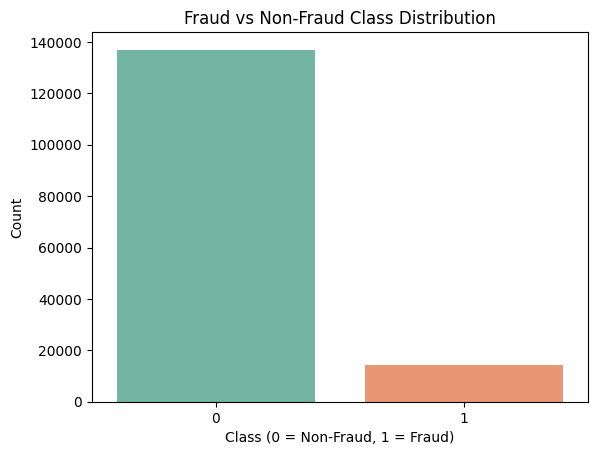


⚖️ Class Distribution (normalized):
class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='class', data=fraud_df_clean, palette='Set2')
plt.title("Fraud vs Non-Fraud Class Distribution")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# Print class balance %
fraud_ratio = fraud_df_clean['class'].value_counts(normalize=True)
print(f"\n⚖️ Class Distribution (normalized):\n{fraud_ratio}")


Purchase Value by Class (Boxplot)

C:\Users\filimon.hailemariam\AppData\Local\Temp\ipykernel_21636\1322287570.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=fraud_df_clean, x='class', y='purchase_value', palette='Set3')


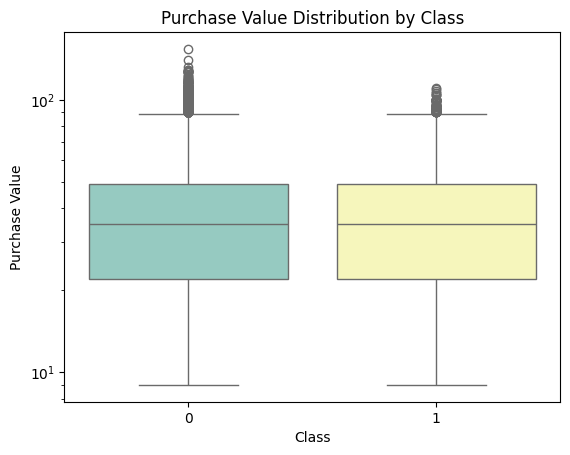

In [11]:
sns.boxplot(data=fraud_df_clean, x='class', y='purchase_value', palette='Set3')
plt.title("Purchase Value Distribution by Class")
plt.xlabel("Class")
plt.ylabel("Purchase Value")
plt.yscale('log')  # Handle skew
plt.show()


Age Distribution (Univariate + by Class)

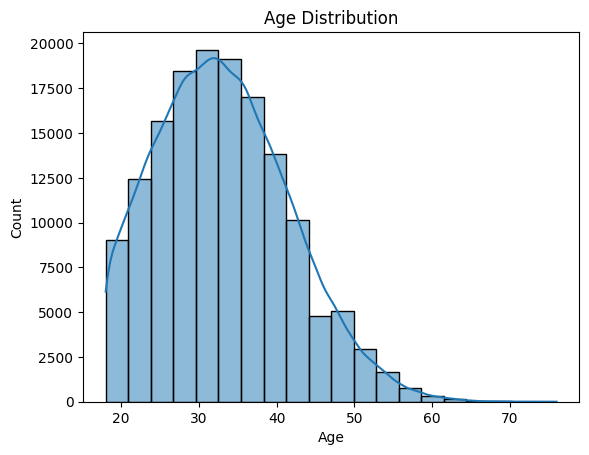

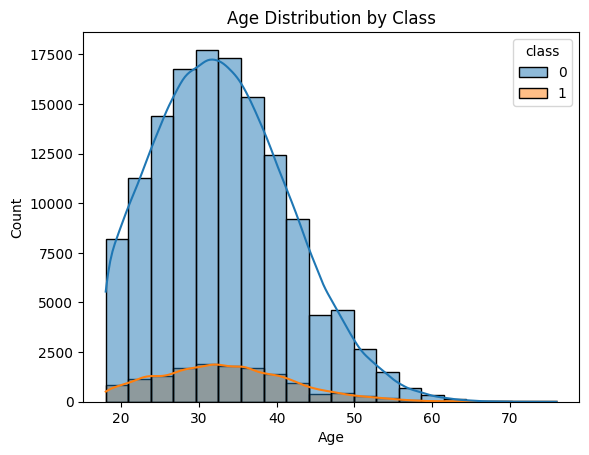

In [12]:
sns.histplot(data=fraud_df_clean, x='age', bins=20, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

sns.histplot(data=fraud_df_clean, x='age', hue='class', bins=20, kde=True)
plt.title("Age Distribution by Class")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


Fraud by Source, Browser, and Sex (Bivariate)

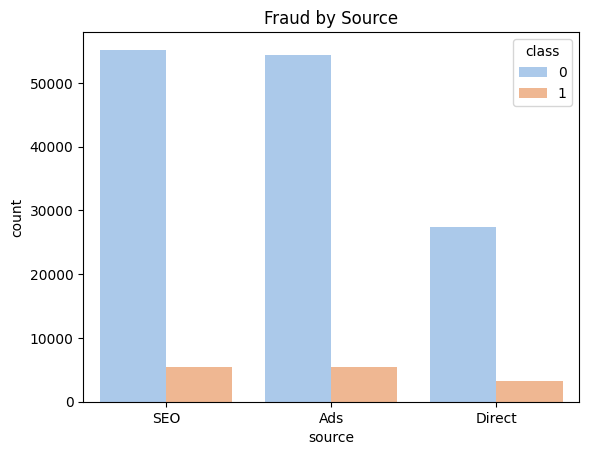

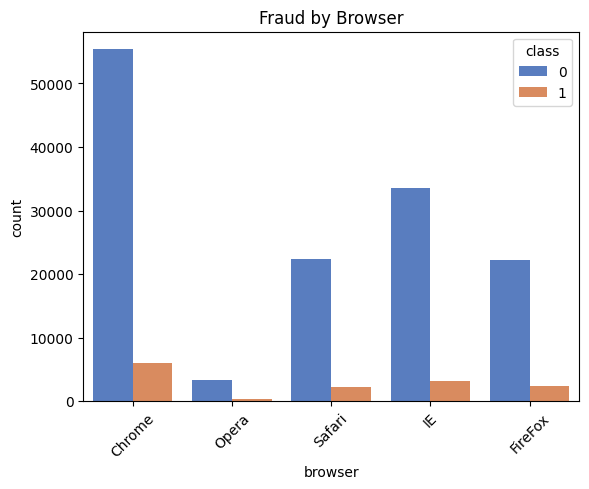

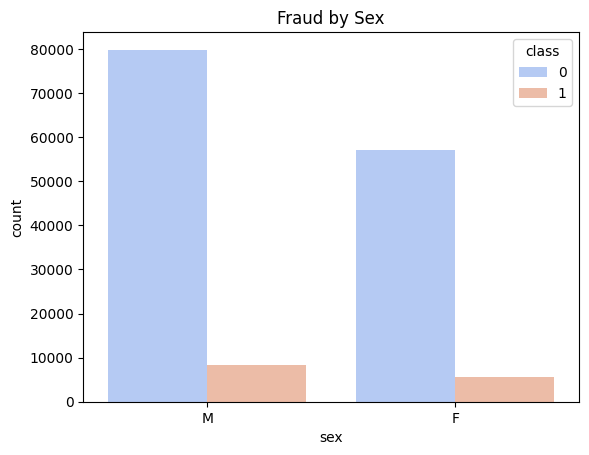

In [13]:
# Source vs Class
sns.countplot(data=fraud_df_clean, x='source', hue='class', palette='pastel')
plt.title("Fraud by Source")
plt.show()

# Browser vs Class
sns.countplot(data=fraud_df_clean, x='browser', hue='class', palette='muted')
plt.title("Fraud by Browser")
plt.xticks(rotation=45)
plt.show()

# Sex vs Class
sns.countplot(data=fraud_df_clean, x='sex', hue='class', palette='coolwarm')
plt.title("Fraud by Sex")
plt.show()


Duplicates & Unique Analysis

In [14]:
print("🔍 Unique values:")
print("Users:", fraud_df_clean['user_id'].nunique())
print("Devices:", fraud_df_clean['device_id'].nunique())
print("IP Addresses:", fraud_df_clean['ip_address'].nunique())


🔍 Unique values:
Users: 151112
Devices: 137956
IP Addresses: 143512
